In [ ]:
#Crear un kernel con string API

In [56]:
import os
import sys  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


input_path = "../data/raw/"
output_path = "../data/output/"

if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Created output directory: {output_path}")

In [57]:
#Abrir el archivo de datos
ibd0 = pd.read_csv(os.path.join(input_path, 'ibd0.tsv'), sep='\t')
# dejar eid como índice
ibd0.set_index('eid', inplace=True)
# En la columna Disease convertir UC y CD a IBD
ibd0['Disease'] = ibd0['Disease'].replace({'UC': 'IBD', 'CD': 'IBD'})
# En la columna Disease convertir IBD a 1 y el resto a 0
ibd0['Disease'] = ibd0['Disease'].replace({'IBD': 1, 'Control': 0})
# En la columna Disease convertir IBD a 1
# quitar las 26 primeras columnas para quedarme solo con las proteínas
ibd_proteins = ibd0.iloc[:, 26:]
# Nombres de las columnas como lista
proteins_names = ibd_proteins.columns.tolist()
# Escribir los nombres de las proteínas en un archivo
with open(os.path.join(output_path, 'proteins.txt'), 'w') as f:
    for protein in proteins_names:
        f.write(f"{protein}\n")


/var/folders/bf/fdxk2h0901v934ldwnk_10x00000gn/T/ipykernel_78900/3053515530.py:2: DtypeWarning: Columns (1,2,3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ibd0 = pd.read_csv(os.path.join(input_path, 'ibd0.tsv'), sep='\t')
/var/folders/bf/fdxk2h0901v934ldwnk_10x00000gn/T/ipykernel_78900/3053515530.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ibd0['Disease'] = ibd0['Disease'].replace({'IBD': 1, 'Control': 0})


In [58]:
# Crear la matriz de interacciones de proteínas usando la API de STRING
string_api_url = "https://version-12-0.string-db.org/api"
output_format = "tsv"
method = "network"

request_url = "/".join([string_api_url, output_format, method])

params = {
    "identifiers" : "%0d".join(proteins_names),
    "species" : 9606,
    "caller_identity" : "www.awesome_app.org"
}

response = requests.post(request_url, data=params)

with open(os.path.join(output_path, "string_results.tsv"), "w", encoding="utf-8") as tsv_file:
    tsv_file.write(response.text)

df = pd.read_csv(os.path.join(output_path, "string_results.tsv"), sep="\t")
score_matrix = pd.DataFrame(0, index=proteins_names, columns=proteins_names, dtype=np.float64)

for _, row in df.iterrows():
    a, b = row['preferredName_A'], row['preferredName_B']
    score = float(row['score']) # 'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'tscore'
    score_matrix.at[a, b] = score
    score_matrix.at[b, a] = score


score_matrix.to_csv(os.path.join(output_path, 'score_matrix.csv'), index=True)
print("Score matrix saved to 'score_matrix.csv' in output directory.")

Score matrix saved to 'score_matrix.csv' in output directory.


In [59]:
interaction_matrix = pd.read_csv(os.path.join(output_path, 'score_matrix.csv'), index_col=0)
#dejar unicamente los nombres de las proteinas que esten en la lista de proteínas original
interaction_matrix = interaction_matrix.loc[proteins_names, proteins_names]

In [60]:
# ordenar las columnas alfabéticamente en ambos DataFrames
sorted_cols = sorted(ibd_proteins.columns)
expression_matrix = ibd_proteins[sorted_cols]
interaction_matrix = interaction_matrix[sorted_cols]

In [61]:
# corroborar si los nombres de las proteínas son los mismos que los de la matriz de interacciones
if set(expression_matrix.columns) == set(interaction_matrix.columns):
    print("Protein names match between expression_matrix and interaction_matrix.")
else:
    print("Protein names do NOT match.")
    print("In expression_matrix but not in interaction_matrix:", set(expression_matrix.columns) - set(interaction_matrix.columns))
    print("In interaction_matrix but not in expression_matrix:", set(interaction_matrix.columns) - set(expression_matrix.columns))

Protein names match between expression_matrix and interaction_matrix.


In [62]:
# Corroborar 
print(interaction_matrix.columns[1977])
print(expression_matrix.columns[1977])


ZNF174
ZNF174


Paso 0: Preprocesamiento de los datos

In [ ]:

def normalize_dataframe(df: pd.DataFrame, method: str, scale_constant: float = 1.0) -> pd.DataFrame:
    """
    Normalizes a DataFrame using either Median Absolute Deviation (MAD) or Z-score.

    Args:
        df (pd.DataFrame): The input DataFrame to normalize.
        method (str): The normalization method to use ('mad' or 'zscore').
        scale_constant (float): Scaling factor for MAD.

    Returns:
        pd.DataFrame: The normalized DataFrame.
    """
    df_normalized = df.copy() 

    if method == 'mad':
        # --- MAD NORMALIZATION ---
        for col in df_normalized.columns:
            median_val = df_normalized[col].median()
            absolute_deviations = (df_normalized[col] - median_val).abs()
            mad_val = absolute_deviations.median()

            if mad_val > 1e-8:
                df_normalized[col] = (df_normalized[col] - median_val) / (mad_val * scale_constant)
            else:
                # If MAD is zero, set the whole column to zero to avoid division errors
                df_normalized[col] = 0.0
        
        print(f"\nDataFrame normalized with MAD (first 3x3):")
        print(df_normalized.iloc[:3, :3])
        print("-" * 50)
        return df_normalized 
        
    elif method == 'zscore':
        # --- Z-SCORE NORMALIZATION---
        df_normalized = (df - df.mean()) / df.std()
        
        # Replace NaN values with 0
        df_normalized.fillna(0, inplace=True) 

        print(f"\nDataFrame normalized with Z-Score (first 3x3):")
        print(df_normalized.iloc[:3, :3])
        print("-" * 50)
        return df_normalized
    
    else:
        # Handle errors
        raise ValueError("Invalid normalization method specified. Choose 'mad' or 'zscore'.")


# Apply
expression_matrix = normalize_dataframe(expression_matrix, method='zscore')
interaction_matrix = normalize_dataframe(interaction_matrix, method='zscore')




DataFrame normalized with Z-Score (first 3x3):
            AAMDC    AARSD1     ABCA2
eid                                  
2227199  2.010602 -1.164590 -0.441394
5822919 -1.278472 -0.944935  0.144750
3122877 -0.009889 -1.023630 -0.777932
--------------------------------------------------

DataFrame normalized with Z-Score (first 3x3):
        AAMDC    AARSD1     ABCA2
AAMDC     0.0 -0.031761 -0.054636
AARSD1    0.0 -0.031761 -0.054636
ABCA2     0.0 -0.031761 -0.054636
--------------------------------------------------


Paso 1. Crear el grafo con NetworkX

In [ ]:

# Construcción del Grafo para la GNN 

# Crear un objeto grafo vacío no dirigido de NetworkX
G_for_GNN = nx.Graph()

# Añadir proteínas al grafo
# Iterar las proteínas.
for protein_name in interaction_matrix.columns:
    G_for_GNN.add_node(protein_name)

# Definir el umbral de peso para añadir aristas (0 para agregar todas las interacciones))
training_threshold = 0.0 

# Añadir aristas (interacciones) con sus pesos
for i in range(len(interaction_matrix.columns)):
    for j in range(i + 1, len(interaction_matrix.columns)): # Desde i+1 para evitar la diagonal y repeticiones
        p1 = interaction_matrix.columns[i]
        p2 = interaction_matrix.columns[j]
        weight = interaction_matrix.loc[p1, p2]

        # Solo añadir una arista si la interacción es significativa (umbral definido))
        if weight > training_threshold:
            G_for_GNN.add_edge(p1, p2, weight=weight)

print(f"Grafo de Proteínas creado para la GNN:")
print(f"  Número de nodos: {G_for_GNN.number_of_nodes()}")
print(f"  Número de aristas: {G_for_GNN.number_of_edges()} (con umbral > {training_threshold})")
print("-" * 50)

num_patients = expression_matrix.shape[0]  # Número de pacientes (filas en la matriz de expresión)
print(f"Número de pacientes: {num_patients}")




Grafo de Proteínas creado para la GNN:
  Número de nodos: 1982
  Número de aristas: 39654 (con umbral > 0.0)
--------------------------------------------------
Número de pacientes: 22625


In [95]:
# Añadir las características de los nodos (expresiones)
# Para cada proteína se añade como característica el perfil de expresión de todos los pacientes.
for protein in G_for_GNN.nodes:
    if protein in expression_matrix.columns:
        # Extraer la columna de la proteína de la matriz de expresión y se convierte en lista.
        G_for_GNN.nodes[protein]['feature_vector'] = expression_matrix[protein].values.tolist()
    else:
        # Retener si no esta presente alguna proteina en la matriz de expresión
        print(f"Advertencia: Proteína {protein} no encontrada en la matriz de expresión. Se asignan ceros como características.")
        G_for_GNN.nodes[protein]['feature_vector'] = [0.0] * num_patients # Asegurar la misma dimensión

# Verificacion
example_protein = list(G_for_GNN.nodes)[0] # primera prot
print(f"Feature vector para {example_protein}:")
print(G_for_GNN.nodes[example_protein]['feature_vector'][:5], "...") # 5 primeras lineas
print(f"Longitud del feature vector: {len(G_for_GNN.nodes[example_protein]['feature_vector'])}")
print(f"Número de pacientes ({num_patients}).")

Feature vector para AAMDC:
[2.010601634005491, -1.278471935959166, -0.009889049551535493, 0.0, -0.5003665286501977] ...
Longitud del feature vector: 22625
Número de pacientes (22625).


In [66]:
#Extraccion de la clase
patient_labels_raw = ibd0['Disease']
label_mapping = {0: 0, 1: 1}
patient_labels_numeric = patient_labels_raw.map(label_mapping)

Paso 2: Convertir NetworkX Grafo a PyTorch Geometric Data Object


In [ ]:
# 1. Preparar Node Features (x):
# Extraer todos los vectores de características de los nodos.
# 'x' debe ser un tensor 2D donde cada fila es una característica de nodo.
all_feature_vectors = [G_for_GNN.nodes[node]['feature_vector'] for node in G_for_GNN.nodes()]
x = torch.tensor(all_feature_vectors, dtype=torch.float)

#Verificar
print(f"Forma de 'x' (características de nodos): {x.shape}")
print(f"(num_proteins, num_patients)")
print("-" * 50)



Forma de 'x' (características de nodos): torch.Size([1982, 22625])
(num_proteins, num_patients)
--------------------------------------------------


In [ ]:
# 2. Preparar Edge Index (edge_index) - Las conexiones de las aristas:

# Mapeo de nombres de proteínas a índices enteros (0, 1, 2...).
protein_to_idx = {protein: i for i, protein in enumerate(G_for_GNN.nodes())}
edge_list = list(G_for_GNN.edges())

# Lista de índices de aristas. Por ser no dirigido, las aristas van a ambas direcciones.
edge_indices = []
for u, v in edge_list:
    edge_indices.append([protein_to_idx[u], protein_to_idx[v]]) # Dirección u -> v
    edge_indices.append([protein_to_idx[v], protein_to_idx[u]]) # Dirección v -> u

# Convertir a tensor y transponer para obtener la forma (2, num_edges_total)
edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

print(f"Forma de 'edge_index' (conectividad de aristas): {edge_index.shape}")
print(f"Contiene {edge_index.shape[1]} aristas (incluyendo las inversas para NO DIRIGIDO).")
print("-" * 50)



Forma de 'edge_index' (conectividad de aristas): torch.Size([2, 79308])
Contiene 79308 aristas (incluyendo las inversas para no dirigido).
--------------------------------------------------


In [ ]:

# 3. Preparar Edge Attributes (edge_attr - los pesos de interacción):

# Recoger los pesos de las aristas del grafo NetworkX
edge_weights = [G_for_GNN[u][v]['weight'] for u, v in edge_list]

# Duplicar pesos para las aristas inversas (para que coincidan con edge_index).
edge_attr = torch.tensor(edge_weights + edge_weights, dtype=torch.float).unsqueeze(1)

print(f"Forma de 'edge_attr' (atributos de aristas/pesos): {edge_attr.shape}")
print("-" * 50)




Forma de 'edge_attr' (atributos de aristas/pesos): torch.Size([79308, 1])
--------------------------------------------------


In [70]:
#Convertir la clase a vector torch
patient_labels = torch.tensor(patient_labels_numeric.values, dtype=torch.long)

In [71]:
# Crear el objeto PyTorch Geometric Data
# NOTA IMPORTANTE: 'y' (las etiquetas de paciente) NO se incluyen en este objeto Data.
# 'y' se usará por separado en el bucle de entrenamiento porque la clasificación es a nivel de paciente, no de nodo.
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

print("\n--- Objeto PyTorch Geometric 'Data' Creado ---")
print(data)
print(f"Número de nodos: {data.num_nodes}")
print(f"Número de aristas (después de duplicar para no dirigido): {data.num_edges}")
print(f"Dimensiones de características de nodo (num_patients): {data.num_node_features}")
print(f"Dimensiones de atributos de arista (peso): {data.num_edge_features}")
print(f"¿Es el grafo no dirigido (según PyG)? {data.is_undirected()}")


--- Objeto PyTorch Geometric 'Data' Creado ---
Data(x=[1982, 22625], edge_index=[2, 79308], edge_attr=[79308, 1])
Número de nodos: 1982
Número de aristas (después de duplicar para no dirigido): 79308
Dimensiones de características de nodo (num_patients): 22625
Dimensiones de atributos de arista (peso): 1
¿Es el grafo no dirigido (según PyG)? False


Paso 3: Contruir el modelo de GNN seguido de la Red neuronal

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data # Necesario para definir la clase Data creada

class PatientClassifierGNN(nn.Module):
    # Constructor del modelo
    def __init__(self, in_channels, hidden_channels_gnn, protein_embedding_dim, num_classes):
        """
        Inicializa las capas de la GNN y el clasificador de pacientes.

        Args:
            in_channels (int): Dimensión de las características de entrada para cada nodo (proteína).
                                (número de pacientes.)
                                
            hidden_channels_gnn (int): Número de características en la capa oculta de la GNN.
            protein_embedding_dim (int): Dimensión del embedding final que la GNN aprenderá para cada proteína.
            num_classes (int): Número de clases de salida para la clasificación de pacientes (ej., 2 para 'enfermo'/'no enfermo').
        """
        super(PatientClassifierGNN, self).__init__()

        # --- Parte 1: La GNN para aprender embeddings de proteínas ---
        # Primera capa GCN: Transforma las características de entrada (num_patients)
        # a una dimensión oculta (hidden_channels_gnn).
        self.conv1 = GCNConv(in_channels, hidden_channels_gnn) #Cambiar por GAT para grafo de atencion

        # Segunda capa GCN: Transforma la dimensión oculta
        # a la dimensión final del embedding de cada proteína (protein_embedding_dim).
        self.conv2 = GCNConv(hidden_channels_gnn, protein_embedding_dim) #Cambiar por GAT para grafo de atencion

        # --- Parte 2: Capa lineal para clasificar pacientes ---
        # Esta capa toma el embedding de cada paciente (de longitud protein_embedding_dim)
        # y producirá las puntuaciones (logits) para cada clase de paciente.
        self.fc_patient = nn.Linear(protein_embedding_dim, num_classes)

    # Método forward: Define cómo los datos fluyen a través de las capas
    def forward(self, x_protein_features, edge_index, edge_weight, patient_expression_data):
        """
        Define el pase hacia adelante del modelo.

        Args:
            x_protein_features (torch.Tensor): Características de las proteínas (nodos) del grafo.
                                             Forma: (num_proteins, num_patients).
                                             Esto es 'data.x' del objeto PyG Data.
                                             
            edge_index (torch.Tensor): Conectividad de las aristas del grafo.
                                     Forma: (2, num_total_edges).
                                     
            edge_weight (torch.Tensor): Pesos de las aristas del grafo.
                                      Forma: (num_total_edges, 1).
                                      
            patient_expression_data (torch.Tensor): La matriz de expresión original.
                                                   Forma: (num_patients, num_proteins).
                                                   Se usa para combinar los embeddings de proteínas en embeddings de pacientes.

        Returns:
            torch.Tensor: Las puntuaciones (logits) de clasificación para cada paciente.
                          Forma: (num_patients, num_classes).
        """

        # Paso 1: La GNN aprende embeddings para cada proteína
        # x_protein_features (num_proteins, num_patients) -> entrada a la primera GCN
        protein_embeddings = self.conv1(x_protein_features, edge_index, edge_weight=edge_weight)
        protein_embeddings = F.relu(protein_embeddings) # Aplicar función de activación
        protein_embeddings = F.dropout(protein_embeddings, p=0.5, training=self.training) # Aplicar dropout

        # La salida de la segunda GCN son los embeddings finales de cada proteína
        # protein_embeddings ahora tiene forma (num_proteins, protein_embedding_dim)
        protein_embeddings = self.conv2(protein_embeddings, edge_index, edge_weight=edge_weight)

        # Paso 2: Crear el embedding de CADA PACIENTE
        # Multiplicamos la matriz de expresión de pacientes por los embeddings de proteínas.
        # patient_expression_data: (num_patients, num_proteins)
        # protein_embeddings:      (num_proteins, protein_embedding_dim)
        # Resultado de torch.matmul: (num_patients, protein_embedding_dim)
        # Este es el embedding (representación resumida) para cada uno de tus pacientes.
        patient_embeddings_final = torch.matmul(patient_expression_data, protein_embeddings)

        # Paso 3: Clasificador lineal para pacientes
        # Toma el embedding de cada paciente y produce las puntuaciones para las clases.
        # patient_classification_output: (num_patients, num_classes)
        patient_classification_output = self.fc_patient(patient_embeddings_final)

        return patient_classification_output

# --- Instanciar el modelo ---
# Definir los parámetros para el modelo
input_dim = data.num_node_features       # num_patients
hidden_channels_gnn = 64                
protein_embedding_dim = 32               # La dimensión final de los embeddings de las proteínas
num_classes = 2                          # Para 'ibd' o 'no ibd'

# Crear una instancia de tu modelo
model = PatientClassifierGNN(input_dim, hidden_channels_gnn, protein_embedding_dim, num_classes)

print("\n--- Arquitectura del Modelo PatientClassifierGNN ---")
print(model)


--- Arquitectura del Modelo PatientClassifierGNN ---
PatientClassifierGNN(
  (conv1): GCNConv(22625, 64)
  (conv2): GCNConv(64, 32)
  (fc_patient): Linear(in_features=32, out_features=2, bias=True)
)


Paso 4: Bucle de clasificacion
class_weights? Ha sido calculado previamente basándose en el desbalance de clases de tus datos (18,999 controles vs. 3,636 enfermos). Al pasar estos pesos, le estás diciendo a la función de pérdida que los errores cometidos al clasificar la clase minoritaria ("Enfermo") son mucho más costosos que los errores en la clase mayoritaria ("No Enfermo"). Esto fuerza al modelo a prestar más atención a la clase minoritaria y a no ignorarla, lo que era el problema anterior que causaba que todas las predicciones fueran "No Enfermo". en criterion

In [ ]:

# Configuración de Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam, LR REDUCIDA es importante

# CALCULAR PESOS DE CLASE Y CONFIGURAR CRITERION
counts_class_0 = 18999 # No ibd
counts_class_1 = 3636  # ibd
total_samples = counts_class_0 + counts_class_1
num_classes = 2

# Calcular los pesos de clase para CrossEntropyLoss
weights_for_loss = torch.tensor([
    total_samples / (num_classes * counts_class_0), # Peso para Clase 0 (No ibd)
    total_samples / (num_classes * counts_class_1)  # Peso para Clase 1 (ibd)
], dtype=torch.float)

# Mover el modelo y los datos a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device) # Características de nodos y la estructura del grafo
patient_labels = patient_labels.to(device) # Las etiquetas de los pacientes
patient_expression_data_tensor = torch.tensor(expression_matrix.values, dtype=torch.float).to(device) # Matriz de expresión original


#inicializar la función de pérdida con los pesos de clase y moverla al device
criterion = nn.CrossEntropyLoss(weight=weights_for_loss.to(device)) 

# División de Pacientes en Entrenamiento/Validación/Prueba
num_patients_total = len(patient_labels) # Usar la longitud de las etiquetas para el total de pacientes
patient_indices = torch.randperm(num_patients_total) # Índices aleatorios para mezclar pacientes

# Definir los tamaños de los conjuntos
train_patient_size = int(0.7 * num_patients_total) # 70% para entrenamiento
val_patient_size = int(0.15 * num_patients_total) # 15% para validación
test_patient_size = num_patients_total - train_patient_size - val_patient_size # 15% para prueba

# Asignar los índices a cada conjunto
train_patient_indices = patient_indices[:train_patient_size]
val_patient_indices = patient_indices[train_patient_size:train_patient_size + val_patient_size]
test_patient_indices = patient_indices[train_patient_size + val_patient_size:]

print(f"Número de pacientes para entrenamiento: {len(train_patient_indices)}")
print(f"Número de pacientes para validación: {len(val_patient_indices)}")
print(f"Número de pacientes para prueba: {len(test_patient_indices)}")
print("-" * 50)




Número de pacientes para entrenamiento: 15837
Número de pacientes para validación: 3393
Número de pacientes para prueba: 3395
--------------------------------------------------


In [ ]:
# --- Funciones de Entrenamiento y Evaluación ---

def train_patient_classifier():
    """
    Realiza un paso de entrenamiento completo para una época.
    """
    model.train() # Pone el modelo en modo entrenamiento
    optimizer.zero_grad() # Limpia los gradientes de la época anterior

    # Pase hacia adelante: El modelo genera las predicciones para todos los pacientes
    out = model(data.x, data.edge_index, data.edge_attr, patient_expression_data_tensor)

    # Calcula la pérdida para los pacientes del conjunto de entrenamiento
    loss = criterion(out[train_patient_indices], patient_labels[train_patient_indices])

    loss.backward() # Calcula los gradientes
    optimizer.step() # Actualiza los pesos del modelo
    return loss.item() # Retorna el valor de la pérdida

def evaluate_patient_classifier(indices_mask, name=""):
    """
    Evalúa el rendimiento del modelo en un conjunto de datos dado (máscara de índices).
    """
    model.eval() # Pone el modelo en modo evaluación
    with torch.no_grad(): # Desactiva el cálculo de gradientes 
        out = model(data.x, data.edge_index, data.edge_attr, patient_expression_data_tensor)
        
        # Clase predicha para los pacientes en la máscara
        pred = out[indices_mask].argmax(dim=1)
        
        # Comparar las predicciones con las etiquetas reales para calcular la precisión
        correct = (pred == patient_labels[indices_mask]).sum().item() # Número de predicciones correctas
        accuracy = correct / len(indices_mask) # Precisión = correctas / total de pacientes en la máscara
    
    return accuracy



In [ ]:
# Bucle de Entrenamiento
epochs = 1000 # Número de épocas para entrenar el modelo 

for epoch in range(1, epochs + 1):
    loss = train_patient_classifier() # Realiza un paso de entrenamiento

    # Evaluar y mostrar resultados 
    if epoch % 10 == 0: # Cada 10 épocas
        train_acc = evaluate_patient_classifier(train_patient_indices, "Entrenamiento")
        val_acc = evaluate_patient_classifier(val_patient_indices, "Validación")
        
        print(f'Epoch: {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')

print("Entrenamiento Finalizado")

Epoch: 010 | Loss: 2.9275 | Train Acc: 0.5245 | Val Acc: 0.5152
Epoch: 020 | Loss: 1.0273 | Train Acc: 0.5743 | Val Acc: 0.5838
Epoch: 030 | Loss: 0.7986 | Train Acc: 0.6401 | Val Acc: 0.6475
Epoch: 040 | Loss: 0.6902 | Train Acc: 0.7581 | Val Acc: 0.7630
Epoch: 050 | Loss: 0.7013 | Train Acc: 0.6247 | Val Acc: 0.6337
Epoch: 060 | Loss: 0.6857 | Train Acc: 0.6773 | Val Acc: 0.6849
Epoch: 070 | Loss: 0.6854 | Train Acc: 0.7320 | Val Acc: 0.7439
Epoch: 080 | Loss: 0.6833 | Train Acc: 0.6929 | Val Acc: 0.7044
Epoch: 090 | Loss: 0.6811 | Train Acc: 0.6616 | Val Acc: 0.6693
Epoch: 100 | Loss: 0.6834 | Train Acc: 0.6448 | Val Acc: 0.6510
Epoch: 110 | Loss: 0.6800 | Train Acc: 0.6377 | Val Acc: 0.6454
Epoch: 120 | Loss: 0.6799 | Train Acc: 0.6288 | Val Acc: 0.6369
Epoch: 130 | Loss: 0.6803 | Train Acc: 0.6213 | Val Acc: 0.6278
Epoch: 140 | Loss: 0.6827 | Train Acc: 0.6160 | Val Acc: 0.6204
Epoch: 150 | Loss: 0.6800 | Train Acc: 0.6105 | Val Acc: 0.6130
Epoch: 160 | Loss: 0.6820 | Train Acc: 0

In [ ]:

# Evaluación Final con en el Conjunto de Prueba
test_acc = evaluate_patient_classifier(test_patient_indices, "Prueba Final")
print(f'\nRendimiento Final en el Conjunto de Prueba: {test_acc:.4f}')

# Obtener los embeddings de pacientes después del entrenamiento
model.eval() # Poner el modelo en modo evaluación
with torch.no_grad():
    # Pasar los datos a través del modelo hasta la capa de embeddings de pacientes
    protein_embeddings_final = model.conv2(
        F.relu(model.conv1(data.x, data.edge_index, data.edge_attr)),
        data.edge_index,
        data.edge_attr
    )
    all_patient_embeddings = torch.matmul(patient_expression_data_tensor, protein_embeddings_final)

print("\nEmbeddings de Pacientes (primeros 5):")
print(all_patient_embeddings[:5])
print(f"Forma de los embeddings de paciente: {all_patient_embeddings.shape}")


Rendimiento Final en el Conjunto de Prueba: 0.5832

Embeddings de Pacientes (primeros 5):
tensor([[-1.9482e+00, -1.7485e+00, -1.7777e+00,  4.3240e+00,  4.2896e-01,
         -7.6787e-01, -3.5324e-01, -1.1290e+00,  2.3823e+00,  2.9021e+00,
         -1.8147e+00,  4.1682e+00,  2.5186e+00, -2.2686e-01,  3.7424e+00,
          3.7543e+00, -3.0355e+00, -4.1239e+00, -2.1872e+00, -1.8248e+00,
         -2.3681e+00,  4.1280e-02,  3.7778e+00, -1.2763e+00, -4.2887e+00,
          3.5528e+00,  3.0412e+00, -5.0456e+00, -4.2878e-02, -4.4607e+00,
         -2.8250e+00,  2.6684e+00],
        [ 5.1188e-03, -2.7782e-01,  1.8198e-01, -1.0240e-01, -1.6218e-01,
          5.0988e-01,  1.7208e+00, -2.3431e-01, -1.8554e-01, -1.9511e-01,
          2.1281e-01, -3.2654e-01,  8.2060e-03,  1.8390e-03, -2.6309e-01,
         -1.4779e-01,  3.3475e-01,  4.5963e-01, -7.1636e-03,  1.5432e+00,
          3.2657e-02, -2.0169e-01, -2.7149e-01,  1.9699e-01,  4.2106e-01,
         -1.7553e-01, -6.2110e-01,  4.1362e-01, -1.9555e-01

--- Métricas de Rendimiento en el Conjunto de Prueba ---
Precisión (Accuracy): 0.5832
Precisión (Precision): 0.2042
Exhaustividad (Recall): 0.5132
Puntuación F1 (F1-Score): 0.2921
Área bajo la Curva ROC (AUC-ROC): 0.5789
--------------------------------------------------


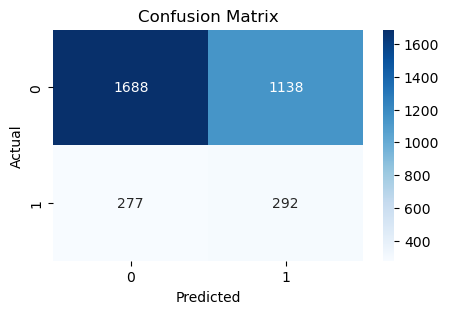

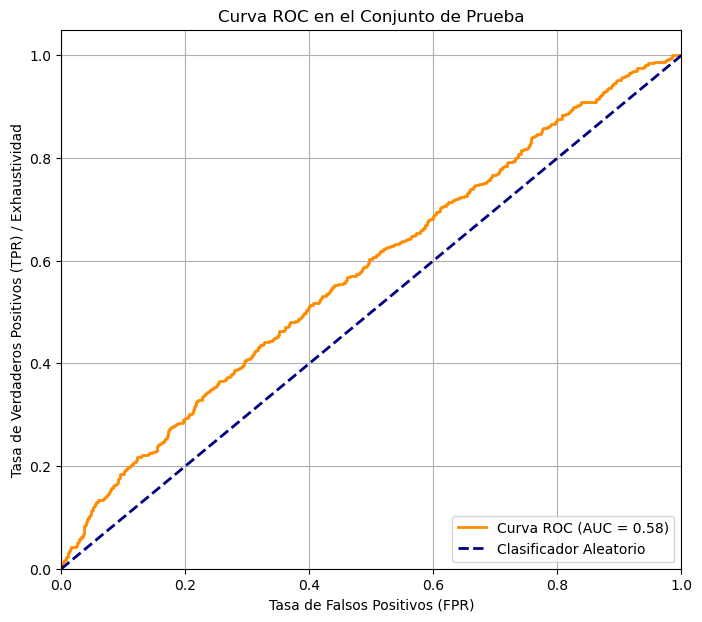


--- Reporte de Clasificación Completo ---
              precision    recall  f1-score   support

           0       0.86      0.60      0.70      2826
           1       0.20      0.51      0.29       569

    accuracy                           0.58      3395
   macro avg       0.53      0.56      0.50      3395
weighted avg       0.75      0.58      0.64      3395

--------------------------------------------------


In [ ]:
# Ver metricas del modelo 

import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


#Poner el modelo en modo evaluación y obtener predicciones
model.eval() # Desactiva Dropout y Batch Normalization para inferencia

with torch.no_grad():
    # Pasar todos los datos a través del modelo para obtener los logits
    logits_all_patients = model(data.x.to(device), data.edge_index.to(device),
                                data.edge_attr.to(device), patient_expression_data_tensor.to(device))

    # Seleccionar solo los logits para los pacientes del conjunto de prueba
    logits_test = logits_all_patients[test_patient_indices]

    # Obtener las etiquetas reales para el conjunto de prueba
    labels_test = patient_labels[test_patient_indices]

    # Convertir logits a probabilidades (para la curva ROC y AUC) con softmax
    probabilities_test = F.softmax(logits_test, dim=1)
    # Para AUC, necesitamos la probabilidad de la clase positiva (1)
    probabilities_positive_class = probabilities_test[:, 1].cpu().numpy()

    # Obtener las predicciones de clase (0 o 1) tomando el índice con la mayor probabilidad
    predicted_classes = torch.argmax(logits_test, dim=1).cpu().numpy()

    # Mover las etiquetas reales a NumPy para usar con scikit-learn
    true_classes = labels_test.cpu().numpy()


# --- 2. Calcular y mostrar las métricas de rendimiento ---

print("--- Métricas de Rendimiento en el Conjunto de Prueba ---")

# Precisión (Accuracy)
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Precisión (Accuracy): {test_accuracy:.4f}")

# Precisión, Exhaustividad, F1-Score (para la clase positiva, asumiendo 1)
test_precision = precision_score(true_classes, predicted_classes, average='binary')
print(f"Precisión (Precision): {test_precision:.4f}")

test_recall = recall_score(true_classes, predicted_classes, average='binary')
print(f"Exhaustividad (Recall): {test_recall:.4f}")

test_f1 = f1_score(true_classes, predicted_classes, average='binary')
print(f"Puntuación F1 (F1-Score): {test_f1:.4f}")

# Área bajo la Curva ROC (AUC-ROC)
# Requiere probabilidades, no solo clases predichas
test_auc_roc = roc_auc_score(true_classes, probabilities_positive_class)
print(f"Área bajo la Curva ROC (AUC-ROC): {test_auc_roc:.4f}")

print("-" * 50)

# --- 3. Generar Gráficos ---

# Definir los nombres de las clases (ajusta si tus etiquetas son diferentes)
class_names = ['0', '1']  # 0: No Enfermo, 1: Enfermo

# GRÁFICO 1: Matriz de Confusión 
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# GRÁFICO 2: Curva ROC 
fpr, tpr, thresholds = roc_curve(true_classes, probabilities_positive_class)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)') # 1 - Especificidad
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Exhaustividad') # Sensibilidad
plt.title('Curva ROC en el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.grid(True)


plt.show()


# Reporte de Clasificación completo 

print("\n--- Reporte de Clasificación Completo ---")
print(classification_report(true_classes, predicted_classes, target_names=class_names))
print("-" * 50)

